# Drainage stability 01

When simulating, the head may cross the elevation of the tile drains or ground surface. When this happens de drainage resistance changes from `infinity` to `c_drain` when the head rises or from `c_drain` to `infinity` when the head is descending.
To deal with this in a managed fashion, when this happens during a time step, the moment at which this occurs is computed and the head is simulated up to the point at which it touches the drain elevation. At that point, the resistance is changed and the simulation is resumed until the end of the timestep is reached. The idea is that this yields a stable simulation, without sawtoothing.

The implementation, however, stills shows sawtoothing after the head hits the drainage level. This workbook tries to find out why this unexpected behavior occurs and seeks a way to prevent it.

This notebook shows, that it is possible that a rising water table turn to a declining one upon passing the drainage level, where the drainage resistance changes from infinity to a low value. This can not in general be prevented, and so the swawtoothing is not solved by the method that simulates onto the time that the drainage level is passed and then contines with the adapted drainage resistance. This was difficult to prove. But it is now shown at the bottom of this notebook. It is, therefore, in general possible to let a rising water table flip to a declining one when the water table passes the drain elevation and the drainage resistance is suddenly reduced. Whether this happens depends on the combination of the drainage elevation, the ditch level and the head in the underlying aquifer and how low the cdr is. But in general this method is not suitable. Therefore, another method is chosen, which will be elaborated in the next notebook (same name ending on 02). TO 2020-09-19

@TO 2020-09-16

The governing partial differential equation

$$kD\frac{d^{2}h}{dx^{2}}	=-N+\frac{h-\phi}{c}+\frac{h-z_{dr}}{c_{dr}}$$

is equivalent to 

$$kD\frac{d^{2}h}{dx^{2}}=-N+\frac{h-\hat{\phi}}{\hat{c}}$$

with

$$\hat{c}=\frac{c_{dr}c}{c_{dr}+c}$$

and

$$\hat{\phi}=\frac{c_{dr}\phi+cz_{dr}}{c_{dr}+c}$$

Therefore, the solution for the transient approach followd in GGOR is

$$\overline{h}-\widehat{\phi}=\left(\overline{h}_{0}-\widehat{\phi}\right)e^{-\frac{t-t_{0}}{\widehat{T}}}+\left\{ N\widehat{c}-\widehat{\Lambda}\left[N\widehat{c}-\left(h_{LR}-\widehat{\phi}\right)\right]\right\} \left(1-e^{-\frac{t-t_{0}}{\widehat{T}}}\right)$$

with

$$\widehat{T}=\mu\widehat{c}$$

and

$$\widehat{\Lambda}=\frac{1}{\frac{b}{\widehat{\lambda}}\mbox{ctanh}\frac{b}{\widehat{\lambda}}+\frac{b/\widehat{c}}{D/w}}$$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import special
import pdb

In [12]:
def newfig(title='title?', xlabel='xlabel?', ylabel='ylabel?', xscale='linear', yscale='linear',
           xlim=None, ylim=None, size_inches=(12, 11), **kwargs):
    """Return ax for new plot."""
    fig, ax = plt.subplots()
    fig.set_size_inches(size_inches)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.grid()
    return ax

In [39]:
# parameters
N = 0.05
h0, phi, hLR, hdr,  = 0., 0.5, 0.5, 1.0
b, mu, k, D, c, cdrain, w = 75., 0.15, 10., 10., 150, 5., 0.5
tend = 40

kw = {'N': N, 'h0': h0, 'phi': phi, 'hLR': hLR, 'hdr': hdr,
'b':b, 'mu': mu, 'k': k, 'D': D, 'c': c, 'cdrain': cdrain, 
      'rising': np.nan,'w': w, 'tend': tend}

kw

{'N': 0.05,
 'h0': 0.0,
 'phi': 0.5,
 'hLR': 0.5,
 'hdr': 1.0,
 'b': 75.0,
 'mu': 0.15,
 'k': 10.0,
 'D': 10.0,
 'c': 150,
 'cdrain': 5.0,
 'rising': nan,
 'w': 0.5,
 'tend': 40}

In [57]:
def get_cdr(h0=None, hdr=None, cdrain=None, htol=None, rising=None, **kw):
    if h0 > hdr + htol:
        cdr = np.inf
    elif h0 < hdr - htol:
        cdr = cdrain
        if rising or np.isnan(rising):
            cdr = np.inf
        else:
            cdr = cdrain
    return cdr

def headt(N=None, tau=None, Th=None, phih=None, h0=None,
          hlr=None, ch=None, Lamh=None, **kw): 
    e = np.exp(- tau / Th)
    B = N * ch - (N * ch - (hLR - phih)) * Lamh
    htau = phih + (h0 - phih) * e + B * (1 -e)
    dhdt = (phih - h0) * e + B * e
    return htau, dhdt

def plot_all(ax=None, t=None, ht=None, h0=None, phi=None, phih=None,
             tauhit=None, hthit=None, rising=None, **kw):
    ax.hlines(hdr, t[0], t[-1], label='hdr', lw = 0.5, color='green')
    ax.hlines(h0,  t[0], t[-1], label='h0' , lw=0.5, color='blue')
    ax.plot(t, ht, '.-', label='head', lw=2, color='black')
    ax2 = ax.twinx()
    ax2.set_ylabel('dhdt')
    ax2.plot(t, dhdt, label=dhdt)
    #pdb.set_trace()    
    if tauhit:
        ax.hlines(phih, t[0], t[ 0] + tauhit, label='phih', lw=2, color='red')
        ax.hlines(phi,  t[0], t[ 0] + tauhit, label='phi' , lw=0.5, color='purple')
        ax.plot(t[0] + tauhit, hthit, 'ro', label='hit')    
    print('tauhit = {}, rising = {}'.format(tauhit, rising))

# Because cdr is inf for h below hdr, the way ch and phih are calculated matter!
def values(b=None, c=None, cdrain=None, hdr=None, h0=None, phi=None, hLR=None,
           N=None, rising=None, k=None, D=None, **kw):
    #pdb.set_trace()
    cdr = get_cdr(h0=h0, cdrain=cdrain, hdr=hdr, rising=rising, htol=0.001, **kw)
    ch  = c / (c / cdr + 1)
    phih = (phi  + hdr * c / cdr) / (c / cdr + 1)
    lamh = np.sqrt(k * D * ch)
    Th   = mu * ch
    Lamh = (1 /((b / lamh) *np.cosh(b / lamh)
            / np.sinh(b / lamh) + (b / ch)/ (D / w)))
    B = N * ch - (N * ch - (hLR - phih)) * Lamh
    rising = (phih - h0 + B) > 0
    logarg = (h0 - phih - B) / (hdr - phih - B)
    if logarg > 0:
        tauhit =  Th * np.log(logarg)
    else:
        tauhit = np.nan    
    return {'cdr':cdr, 'ch': ch, 'phih': phih, 'Th': Th, 'lamh': lamh,
          'Lamh':Lamh, 'B':B, 'tauhit': tauhit, 'rising':rising}

{'N': 0.05, 'h0': 0.0, 'phi': 0.5, 'hLR': 0.5, 'hdr': 1.0, 'b': 75.0, 'mu': 0.15, 'k': 10.0, 'D': 10.0, 'c': 150, 'cdrain': 5.0, 'rising': True, 'w': 0.5, 'tend': 40, 'cdr': inf, 'ch': 150.0, 'phih': 0.5, 'Th': 22.5, 'lamh': 122.47448713915891, 'Lamh': 0.8718528268319834, 'B': 0.9611037987601243, 'tauhit': 25.949796253967083, 'ax': <AxesSubplot:title={'center':'tauhit=25.95, rising =True, kD=100.0, c=150, cdr=inf, ch=150.0, phi=0.5, phih=0.5, N=0.05'}, xlabel='tau [d]', ylabel='elevation and head'>, 'htauhit': 1.0, 'hthit': 1.0}
tauhit = 25.949796253967083, rising = True


UnboundLocalError: local variable 'cdr' referenced before assignment

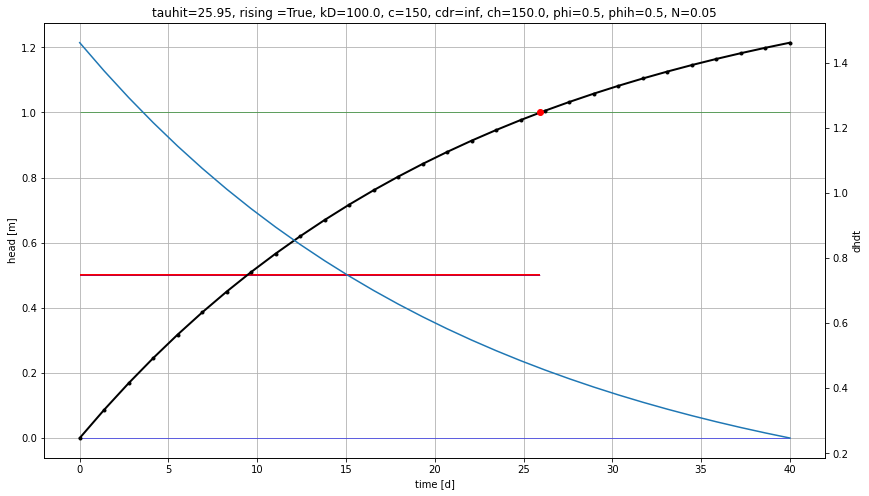

In [60]:
kw.update(values(**kw))
print(kw)

title=('tauhit={:.4g}, rising ={}, kD={}, c={}, cdr={}, ch={}'.format(
        kw['tauhit'], kw['rising'], kw['k'] * kw['D'], kw['c'], kw['cdr'], kw['ch']) + 
        ', phi={}, phih={}, N={}'.format(kw['phi'], kw['phih'], kw['N']))

ax = newfig(title, 'time [d]', 'head [m]', size_inches=(14, 8))
kw['ax'] = ax

t  = np.linspace(0, tend, 30)
ht, dhdt = headt(tau=t-t[0], **kw)
hthit, _ = headt(tau=t[0] + kw['tauhit'], **kw)
kw.update({'hthit':hthit})
plot_all(t=t, ht=ht, **kw)

# Second time step form thit
t =np.linspace(t[0] + kw['tauhit'], tend, 30)
kw.update({'h0':hthit})
kw.update(values(**kw))

ht, dhdt = headt(tau=t-t[0], **kw)
hthit, _ = headt(tau=t[0] + kw['tauhit'], **kw)
kw.update({'hthit':hthit})
plot_all(t=t, ht=ht, **kw)

ax.set_title(title)
ax.set_xlabel('tau [d]')
ax.set_ylabel('elevation and head')
ax.legend()
plt.show()
     

In [5]:
pdb.pm()

reading .pdbrc file in ~/Theo   ... done
> <ipython-input-3-511884838418>(14)headt()
     12 def headt(N=None, tau=None, Th=None, phih=None, h0=None,
     13           hlr=None, ch=None, Lambh=None, **kw): 
---> 14     e = np.exp(- tau / Th)
     15     B = N * ch - (N * ch - (hLR - phih)) * Lamh
     16     htau = phih + (h0 - phih) * e + B * (1 -e)

ipdb> l
      9             cdr = cdrain
     10     return cdr
     11 
     12 def headt(N=None, tau=None, Th=None, phih=None, h0=None,
     13           hlr=None, ch=None, Lambh=None, **kw): 
---> 14     e = np.exp(- tau / Th)
     15     B = N * ch - (N * ch - (hLR - phih)) * Lamh
     16     htau = phih + (h0 - phih) * e + B * (1 -e)
     17     dhdt = (phih - h0) * e + B * e
     18     return htau, dhdt
     19 

ipdb> Th
22.5
ipdb> tau
ipdb> q


In [6]:
kw

{'N': 0.002,
 'h0': 0.0,
 'phi': 0.5,
 'hLR': 0.5,
 'hdr': 1.0,
 'b': 75.0,
 'mu': 0.15,
 'k': 10.0,
 'D': 10.0,
 'c': 150,
 'cdrain': 5.0,
 'rising': True,
 'w': 0.5,
 'tend': 40,
 'ax': <AxesSubplot:>,
 'cdr': inf,
 'ch': 150.0,
 'phih': 0.5,
 'Th': 22.5,
 'lamh': 122.47448713915891,
 'Lamh': 0.8718528268319834,
 'B': 0.03844415195040496,
 'tauhit': nan}

In [259]:
# kw = b=b, wo=wo, wi=wi, c=c, cdrain=cdrain, mu=mu, k=k, D=D,

def update_vars(N=None, phi=None, hlr=None, hdr=None, cdr=None, 
                b=None, wo=None, wi=None, c=None, cdrain=None, mu=None,
                k=None, D=None, **kw):
    """Update variables that change with cdr."""
    w_ = wi if hstrt > hlr else wo
    ch     = c  / (1 + c / cdr)    # c_hat (see theory)
    Th     = mu * ch
    phih   = (phi + (c / cdr) * hdr) / (1 + c / cdr)
    lamh   = np.sqrt(k * D * ch)
    Lamh  = 1 / ((b / lamh) / np.tanh(b / lamh) + (w_ / D) * (ch / b))
    B      = N * ch - (N * ch - (hlr - phih)) * Lamh
    return w_, ch, Th, phih, lamh, Lamh, B


def start_trace():
    time = np.linspace(0, 60, 121)
    Dt = np.diff(time); Dt = np.hstack((Dt[0], Dt))
    rech = 0.010
    q_up = 0.010
    phi  = 0.0
    hlr  = 0.7
    hdr  = 1.2
    k, D, c, cdrain = 10., 10., 150, 10
    wo, wi = 1., 2.
    lam = k * D * c
    T = mu * c
    htol = 0.01
    
    kwvars = {'b':b, 'wo':wo, 'wi':wi, 'c':c, 'cdrain':cdrain, 'mu':mu,
                     'k':k, 'D':D}
    if hlr > hdr:
        cdr = cdrain
    else:
        cdr = np.Inf

    h0 = np.zeros(len(time) + 1); h0[0] = hlr
    h1 = np.zeros(len(time) + 1)
    dhdt = np.zeros(len(time))
    RECH = np.ones_like(Dt) * rech; RECH[time < 10] = 0.; RECH[time > 30] = 0.

    solution_name = 'L1q'

    #pdb.set_trace()

    substep_max = 0
    for it, (dt, t1, N) in enumerate(zip(Dt, np.cumsum(Dt), RECH)):

        hstrt = h0[it]
        substep_counter = 0
        
        if solution_name == 'L1q':
                phi = hstrt + c * q_up

        w_, ch, Th, phih, lamh, Lamh, B = update_vars(
                N=N, phi=phi, hlr=hlr, hdr=hdr, cdr=cdr, **kwvars)

        t = t1 - dt
        while t < t1: # while not done
            # Check that nothign goes astray.
            substep_counter += 1

            r  = (phih - hstrt + B) / (phih - hdr + B)
            if r > 1:
                dtau = min(Th * np.log(r), t1 - t)
            else:
                dtau = t1 - t
            
            # Compute head at and of current (sub)-time step
            e = np.exp(-dtau / Th)     # At and of current time step.
            f = (1 - e) / (dtau / Th)  # Exact aveage over current time step.

            # head at t + dtau
            hend = phih + (hstrt - phih) * e + (
                N * ch -  Lamh * (N * ch - (hlr - phih))) * (1 - e)

            dhdt[it]= (phih - hstrt + N *ch - Lamh *(N * ch - (hlr - phih))) * e
            
            # Exact mean head between t and t + dtau
            h0mean  = phih + (hstrt - phih) * f + (
                N * ch - Lamh * (N * ch - (hlr - phih))) * (1 - f)

            # Upate for next cycle within timestep
            hstrt = hend
            t += dtau

            if hstrt > hdr - htol and hstrt < hdr + htol:
                V = phih - hstrt + N * ch - Lamh * (N * ch - (hlr - phih))
                if V > 0.: cdr = cdrain # rising                    
                if V < 0.: cdr = np.inf # descending                    
                if V != 0.:
                    w_, ch, Th, phih, lamh, Lamh, B = update_vars(
                            N=N, phi=phi, hlr=hlr, hdr=hdr, cdr=cdr, **kwvars)            

            print('it={}, N={} cdr={} r={:.3f}, dtau={:.2f} hstrt={:.2f}, dhdt={:.2f}'
              .format(it, N, cdr, r, dtau, hstrt, dhdt[it]) +
             ' hdr={:.2f} hlr={:.2f} phi={:.2f}'.format(hdr, hlr, phi))

            # END for t < t1
        substep_max = max(substep_counter, substep_max)
        # Update phi for the next iterataion
        #if solution_name == 'L1q':
        #    phi = (h0[it] + hend) / 2 + c * q_up
        # END iter

        h0[it + 1] = hend
        h1[it + 1] = phi
        # END it

    print("substep_max = ",substep_max)
    ax = newfig('h', 'tijd', 'head [m]')
    ax2=ax.twinx()
    ax2.set_ylabel('dhdt [m/d]')
    ax.grid(False)
    ax.plot(time, h0[1:], 'r.-', label='hstrt')
    ax.plot(time, h1[1:], 'g.-', label='phi')
    ax.hlines(hdr, time[0], time[-1], lw=0.5, ls='dashed', color='b', label='hdr')
    ax.vlines(time, 0.5, 1.4, lw=0.25, color='darkgray')
    ax2.plot(time, dhdt, 'r--', label='dhdt')
    ax.legend()
    ax2.legend()


it=0, N=0.0 cdr=inf r=35.618, dtau=0.50 hstrt=0.71, dhdt=0.50 hdr=1.20 hlr=0.70 phi=2.20
it=1, N=0.0 cdr=inf r=27.674, dtau=0.50 hstrt=0.72, dhdt=0.50 hdr=1.20 hlr=0.70 phi=2.21
it=2, N=0.0 cdr=inf r=22.567, dtau=0.50 hstrt=0.73, dhdt=0.49 hdr=1.20 hlr=0.70 phi=2.22
it=3, N=0.0 cdr=inf r=19.008, dtau=0.50 hstrt=0.74, dhdt=0.48 hdr=1.20 hlr=0.70 phi=2.23
it=4, N=0.0 cdr=inf r=16.386, dtau=0.50 hstrt=0.75, dhdt=0.47 hdr=1.20 hlr=0.70 phi=2.24
it=5, N=0.0 cdr=inf r=14.374, dtau=0.50 hstrt=0.77, dhdt=0.47 hdr=1.20 hlr=0.70 phi=2.25
it=6, N=0.0 cdr=inf r=12.782, dtau=0.50 hstrt=0.78, dhdt=0.46 hdr=1.20 hlr=0.70 phi=2.27
it=7, N=0.0 cdr=inf r=11.490, dtau=0.50 hstrt=0.79, dhdt=0.45 hdr=1.20 hlr=0.70 phi=2.28
it=8, N=0.0 cdr=inf r=10.422, dtau=0.50 hstrt=0.80, dhdt=0.45 hdr=1.20 hlr=0.70 phi=2.29
it=9, N=0.0 cdr=inf r=9.523, dtau=0.50 hstrt=0.81, dhdt=0.44 hdr=1.20 hlr=0.70 phi=2.30
it=10, N=0.0 cdr=inf r=8.757, dtau=0.50 hstrt=0.82, dhdt=0.44 hdr=1.20 hlr=0.70 phi=2.31
it=11, N=0.0 cdr=inf r

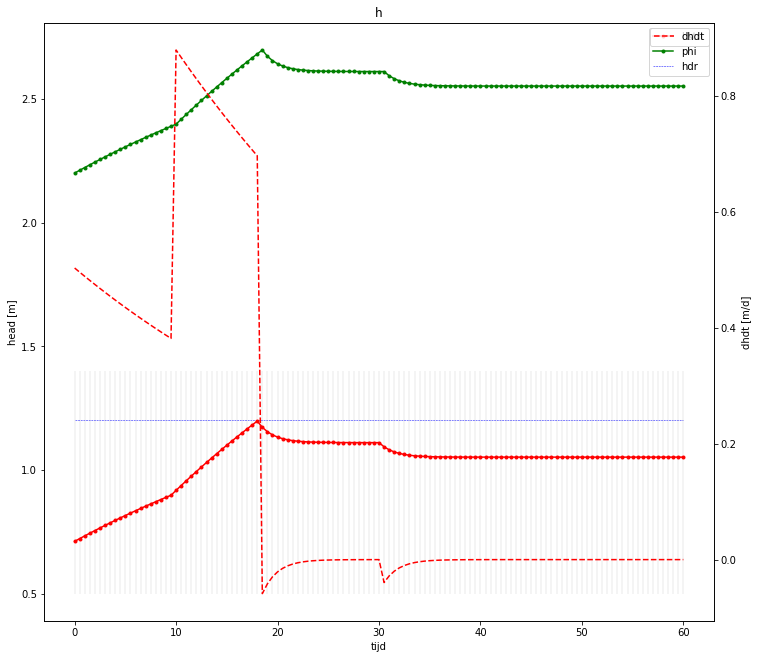

In [260]:
start_trace()

In [262]:
    kwvars = {'b':b, 'wo':wo, 'wi':wi, 'c':c, 'cdrain':cdrain, 'mu':mu,
                     'k':k, 'D':D}

w_, ch, Th, phih, lamh, Lamh, Bh = update_vars(
        N=N, phi=phi, hlr=hlr, hdr=hdr, cdr=cdrain, **kwvars)
w_, c_, T_, phi_, lam_, Lam_, B_ = update_vars(
        N=N, phi=phi, hlr=hlr, hdr=hdr, cdr=np.inf, **kwvars)

print('phih - hdr + Bh = ', phih - hdr + Bh)
print('phi_ - hdr + B_ = ', phi_ - hdr + B_)


phih - hdr + Bh =  -0.068051358401595
phi_ - hdr + B_ =  0.8379205089261383


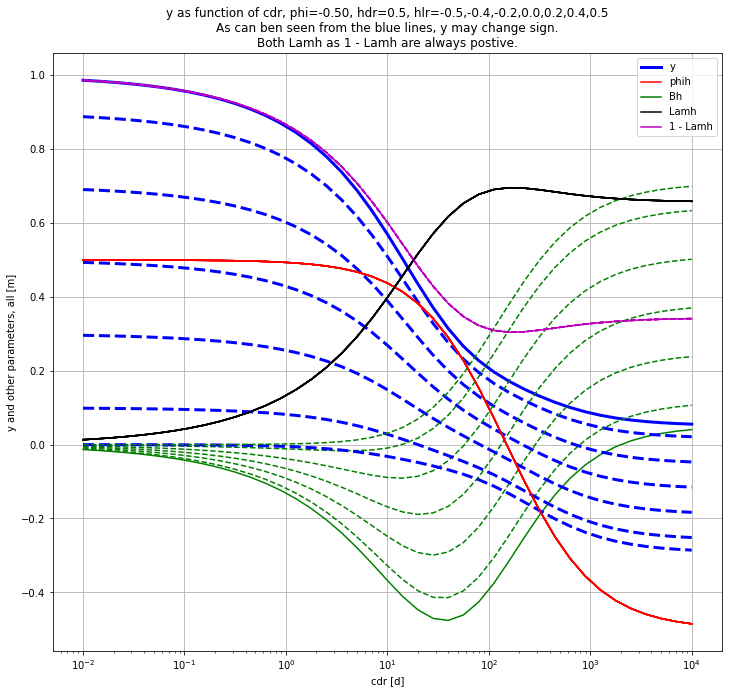

In [318]:
Cdr   = np.logspace(-2, 4, 41)
y     = np.zeros_like(Cdr)
phih_ = np.zeros_like(Cdr)
Bh_   = np.zeros_like(Cdr)
Lamh_ = np.zeros_like(Cdr)
N =  0.001
phi  = -0.5
hlr  = 0.0
hdr  = 0.5

Hlr = [-0.5, -0.4, -0.2, 0., 0.2, 0.4, 0.5]
hlrstr = ','.join([str(s) for s in Hlr])
title = ('y as function of cdr, phi={:.2f}, hdr={}, hlr={}'.format(phi, hdr, hlrstr) +
         '\n' + 'As can ben seen from the blue lines, y may change sign.' +
         '\n' + 'Both Lamh as 1 - Lamh are always postive.')
ax = newfig(title, 'cdr [d]', 'y and other parameters, all [m]', xscale='log')

for j, hlr in enumerate(Hlr):
    for i, cdr in enumerate(Cdr):
        w_, ch, Th, phih, lamh, Lamh, Bh = update_vars(
                N=N, phi=phi, hlr=hlr, hdr=hdr, cdr=cdr, **kwvars)
        y[    i] = ((phih - hlr) + Bh)
        phih_[i] = phih
        Bh_[  i] = Bh
        Lamh_[i] = Lamh
        #print('i {:3d} y {:8.3f} cdr {:8.1f}: phih {:8.4f}, hlr {:8.4f}, Bh {:8.3f}'.
        #      format(i, y[i], cdr, phih, hlr, Bh))
    if j==0:
        ax.plot(Cdr,     y, 'b', lw=3, label='y')
        ax.plot(Cdr, phih_, 'r', label='phih')
        ax.plot(Cdr,  Bh_ , 'g', label='Bh')
        ax.plot(Cdr, Lamh_, 'k', label='Lamh')
        ax.plot(Cdr, 1 - Lamh_, 'm', label='1 - Lamh')
    else:
        ax.plot(Cdr,     y, 'b--', lw=3, label='')
        ax.plot(Cdr, phih_, 'r', label='')
        ax.plot(Cdr,  Bh_ , 'g--', label='')
        ax.plot(Cdr, Lamh_, 'k', label='')
        ax.plot(Cdr, 1 - Lamh_, 'm--', label='')
        
ax.legend()

In [319]:
w_


2.0